# Coding up our own CNN

## What you are going to do

In this exercise, you will create algorithms to train non-linear models like CNNs.

In all of the tasks below, you should use PyTorch to design, train and test your CNN models. You can use matplotlib, pandas and numpy to visualize and study your results.



### Import required libraries and packages

In [18]:
# If you run on Jupyter Lab uncomment bellow comment
#! pip install --quiet "matplotlib" "pytorch-lightning" "pandas" "torchmetrics"

# If you run on google colab uncomment bellow comment
# !pip install "pytorch-lightning" "torchmetrics"  -qq

# If you are running on your IDE (e.g VSCode) select the virtual environment that you have created as your python kernel
import os

import random

import matplotlib.colors as mpcol

import numpy as np # it's numpy, of course we need it!

import pandas as pd # for handling data

import matplotlib.pyplot as plt # for plotting

import torch # this is PyTorch
import torch.nn as nn # The torch.nn module contains the building blocks for our neural networks
from torch.nn import functional as F # functional is a subpackage that contains various different deep learning functions (e.g activation functions)
from torch import optim # is a package that implements various optimization algorithms used for training
from torch.utils.data.dataset import Dataset # We require the Dataset and DataLoader classes if we are handling custom data
from torch.utils.data import DataLoader

from torchvision import transforms

from pytorch_lightning import seed_everything 

from tqdm import tqdm

# For reproducability
seed_everything(1234, workers=True)

# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu') 

Global seed set to 1234


In [19]:
print(device)
print(torch.cuda.is_available())

cuda:0
True


## Design a Shallow CNN and use it to Classify FashionMNIST

In this section you will be training a Shallow CNN to classify images using the data file "Section1_data.npz", which is the Fashion-MNIST dataset that contains images and labels for training, validation and test purposes (The images are 28x28 grayscale images).

You will use PyTorch's inbuilt datasets class, and Pytorch's module class to construct a CNN in order to perform training and testing on the given datasets using stochastic gradient descent (SGD).

| Type of data | Access |
| --- | --- |
| Train data (inputs) | data['arr_0']  |
| Train data (labels)| data['arr_1'] |
| Validation data (inputs) | data['arr_2']  |
| Validation data (labels)| data['arr_3'] |
| Test data (inputs) | data['arr_4']  |
| Test data (labels)| data['arr_5'] |

### Creating a Pytorch dataset for FashionMNIST

In [35]:
class FashionMNIST(Dataset):
    def __init__(self,trn_val_tst = 0, transform=None): # for simplicity we will just use an int to specify our train/test/val split - not the best design!
        # change with your own path
        data = np.load("Section1_data.npz") # make sure to upload the Section1_data.npz file to your working directory!
        if trn_val_tst == 0:
            #trainloader
            self.images = data['arr_0'].T
            self.labels = data['arr_1']
        elif trn_val_tst == 1:
            #valloader
            self.images = data['arr_2'].T
            self.labels = data['arr_3']
        else:
            #testloader
            self.images = data['arr_4'].T
            self.labels = data['arr_5']

        self.images =  np.asarray(self.images).reshape(-1, 28, 28, 1).astype('float32') /255.0 # convert to float 32 for tensors, images are 28x28x1 grayscale
        self.transform = transform # REMEMBER IF WE WANT TO AUGMENT OUR DATA WE PASS THE TRANSFORMS TO THIS CLASS #

    def __len__(self):
        return len(self.labels) # length of labels = length of images

    def __getitem__(self, idx):
        if torch.is_tensor(idx): # idx will be a list of indexes as we will  be BATCHING
            idx = idx.tolist()

        sample = self.images[idx,:] # self.images is a two-dimensional array, the first dimension stores the image index and the second stores the image pixel values
        labels = self.labels[idx]
        if self.transform:  ## If there is a transform, apply it here to your sample
            sample = self.transform(sample)
        return sample, labels

In [36]:
BATCH_SIZE = 128     # the batch size for training task 1
N_WORKERS = 0 # don't worry too much about this

# Data augmentations
transform = transforms.Compose([transforms.ToTensor()])

# Create an instance of the FashionMNIST dataset for the training, validation and test set
# Remember we defined FashionMNIST(trn_val_tst = 0, transform=None), use ints 0-2 to define the train/val/test and make sure to pass in the transform
train_set = FashionMNIST(0,transform=transform)
val_set = FashionMNIST(1,transform=transform)
test_set = FashionMNIST(2,transform=transform)

# Now we need to pass the dataset to the Pytorch dataloader class along with some other arguments
# DataLoader(dataset = dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=N_WORKERS), make sure to shuffle the train dataset!
trainloader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=N_WORKERS)
valloader = DataLoader(val_set, shuffle=False, batch_size=BATCH_SIZE, num_workers=N_WORKERS)
testloader = DataLoader(test_set, shuffle=False, batch_size=BATCH_SIZE, num_workers=N_WORKERS)

### Creating a CNN Model

![image](network_architecture.JPG)

In [37]:
class CNN(nn.Module): # This is our main model
    def __init__(self, learning_rate=1e-4):
        super().__init__()

        self.learning_rate = learning_rate

        # conv1 is 16 1x5x5 kernels -> output is BatchSize-16-24-24 -> output after pool with 2x2 is BS-16-12-12
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1)

        # conv2 is 32 16x5x5 kernels -> output is BS-32-8-8 -> output after pool with 2x2 is BS-32-4-4 (32*4*4 = 512)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1)

        # 512 input, 32 output
        self.fc1 = nn.Linear(32*4*4,32)

        # 32 input, 10 output
        self.out = nn.Linear(32,10) # The output FC layer

        # Define Max Pooling (Default stride = kernel size)
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        #Pass input through conv layers
        # conv 1
        x = F.relu(self.conv1(x))

        x = self.maxpool(x)

        # conv 2
        x = F.relu(self.conv2(x))

        x = self.maxpool(x)

        # flatten for linear layers
        x = x.view(x.shape[0],-1)

        # fc1
        x = F.relu(self.fc1(x))

        # output
        out = self.out(x)
        # don't need softmax here since we'll use cross-entropy as our loss function
        return out

### Training our CNN Model

In [38]:
LEARNING_RATE = 1e-4

loss_function = nn.CrossEntropyLoss()

model = CNN(learning_rate=LEARNING_RATE)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [39]:
# simple empty array to log the loss
loss_log = []

# Perform 10 epochs
for epoch in range(2):
    loop = tqdm(trainloader)
    for idx, (x_batch, y_batch) in enumerate(loop):
        # perform forward pass
        target_pred = model(x_batch)

        # calc loss
        loss = loss_function(target_pred, y_batch)

        # zero gradients from previous step to avoid adding gradients
        optimizer.zero_grad()

        # calculate new gradients
        loss.backward()

        # perform gradient descent
        optimizer.step()

        loss_log.append(loss.item())
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

100%|██████████| 469/469 [00:06<00:00, 70.00it/s]


Epoch: 1, Loss: 2.305793523788452


100%|██████████| 469/469 [00:07<00:00, 61.29it/s]

Epoch: 2, Loss: 2.300710439682007


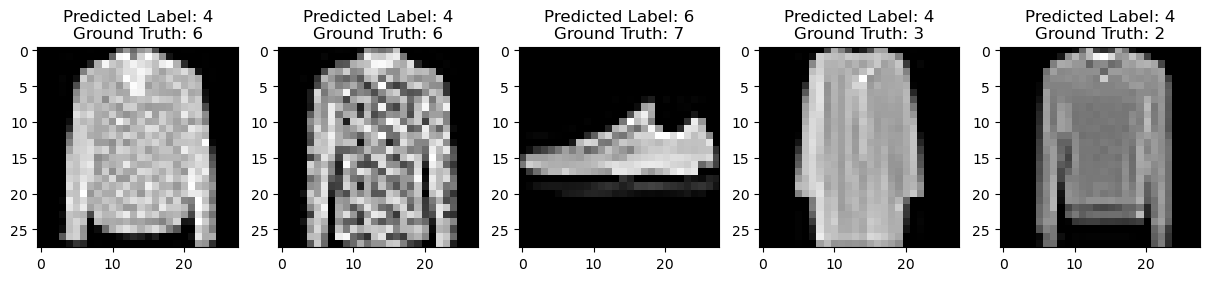

In [40]:
# Generate predictions using predict function
# Take a random test sample
test_data_iterator = iter(testloader)
data, labels = next(test_data_iterator)

predicted_labels = model(data).argmax(1)

data = data.reshape(BATCH_SIZE,28,28) # input data is not in 28x28 format -> for visualisation

input_im = data[0:5] # get first 5 images
ground_truth = labels[0:5] # get labels corresponding to first 5 images
predicted = predicted_labels[0:5] # get predictions corresponding to first 5 images

plt.figure(figsize=(15,8))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(input_im[i], cmap = "gray")
  plt.title(f'Predicted Label: {predicted[i]}\nGround Truth: {ground_truth[i]}')
